<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Computer-aided exploration of the Martian geology
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to compute a favorability map for the selection of landing sites on Mars. A favorable site depends on two main constraints:
* Landing constraints which ensure that the system can land on a given area.
* Scientific targets which must be visited by a rover after landing, if the rover can drive to them.

The notebooks determine this favorability for a rover similar to NASA's Mars 2020 rover at 20 pixels per degree (3 km per pixel at the equator), and investigate our ability to explore Mars with enhanced landing and roving capabilities.

# Fuzzification and fuzzy combination of the scientific targets

Our goal here is to combine all the scientific targets into a single raw scientific favorability, and to combine it with the landing favorability. We still rely on fuzzy logic [[Zadeh, 1965](http://doi.org/10.1016/S0019-9958(65%2990241-X)], but before that we group and prioritize the scientific targets to select only those that could answer the scienfitic objectives of the mission.

## Package imports

Load some functions for data import, data visualization, and favorability computation.

In [1]:
%matplotlib notebook

from skdiscovery.utilities.planetary.raster_management import *
from skdiscovery.utilities.planetary.geographical_computation import compute_longitude_and_latitude_maps
from skdiscovery.utilities.planetary.fast_marching import *
from skdiscovery.utilities.planetary.fuzzy_logic import *
from skdiscovery.utilities.planetary.traverse_emulation import *

import matplotlib.pyplot as plt

## Setting

Geographical setting for the rasters.

In [2]:
mars_radius = 3389500. # meters

master_lon_min = -180.
master_lon_max = 180.
master_lat_min = -90.
master_lat_max = 90.
master_extent = (master_lon_min, master_lon_max, master_lat_min, master_lat_max)

master_width = 7200
master_height = 3600
master_geotransform = define_geotransform(master_lon_min, master_lon_max, 
                                          master_lat_min, master_lat_max, 
                                          master_width, master_height)
master_projection = '''PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]'''

master_spatial_reference_system = osr.SpatialReference(wkt = master_projection)
master_central_meridian = 0.

Folder structure from the base folder *CaseStudyMars_Data*:
<pre>
Base folder:   CaseStudyMars_Data/
               ├── Original_Data/
               │   ├── Interpreted_Data/
               │   ├── MEX/
               │   │   ├── HRSC/
               │   │   └── OMEGA/
               │   ├── MGS/
               │   │   ├── MOLA/
               │   │   └── TES/
               │   ├── MRO/
               │   │   ├── CRISM/
               │   │   └── HiRISE/
Output folder: └── Raster_Data_20ppd/
</pre>

In [3]:
base_folder = '/data/Mars/CaseStudyMars_Data/'
output_folder = 'Raster_Data_20ppd/'

Choose the speed map for the fast marching. The first one is for a rover similar to NASA's Mars 2020 rover, the other ones for rovers with improving capabilities. The notebook must be run independently for each speed map.

In [4]:
speed_affix = ''
# speed_affix = '_DustTraversable'

## Rover's driving time

The prime mission for a rover like Mars 2020 corresponds to one Martian year (668.6 sols, 687 days). A rover is not expected to always drive during that time, because it has to stop for scientific analysis or battery recharging for instance. The time dedicated to traverse ends up being pretty low:  

**MSL**  
* Planned:  
    * 5-20 km [http://mars.nasa.gov/msl/mission/timeline/surfaceops/]  
    * 669 sols (687 days), 18 km [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]  
    * 20 km, with 4.5 km in the first martian year, 1 non-driving sol every 4 sols to account for the non-determinism of the mission, and 150 sols set aside for scientific activites other than sampling and driving [[Welch et al., 2013](http://doi.org/10.1109/SYSoSE.2013.6575245)]  
    * Can be awake about 6 hours per sol in total due to battery limitations [[Welch et al., 2013](http://doi.org/10.1109/SYSoSE.2013.6575245)]  
* Primary: from Curiosity drive logs [http://curiosityrover.com/tracking/drivelog.html], it drove 9 sols during her first martian year, for a distance of 8 km and an average speed of 41.35 m.h<sup>-1</sup>. At this speed, Curiosity would need 19.6 Sols to drive 20 km  

**Mars 2020**
Planned: 669 sols (traverse distances could potentially be between 10-25 km) [[Mustard et al., 2013](http://www.researchgate.net/publication/259219062_Report_of_the_Mars_2020_Science_Definition_Team)]


Expected traverse distances for a MSL-type rover depending on wheel damages [http://www.planetary.org/blogs/emily-lakdawalla/2014/08190630-curiosity-wheel-damage.html]:
* Bedrock with lots of rocks: ~8 kilometers
* Lots of rocks, not on bedrock: 13-14 kilometers
* Bedrock with few rocks (think flagstones): 30-40 kilometers or more
* Smooth or sandy, with few or no rocks: indeterminate (causes no damage)

In [5]:
minimum_driving_time = 0
maximum_driving_time = 25

## Inputs for the fast marching method

Import the longitude, latitude and rover speed maps.

In [6]:
longitude_array, latitude_array = compute_longitude_and_latitude_maps(master_lon_min, master_lon_max, 
                                                                      master_lat_min, master_lat_max, 
                                                                      master_width, master_height)

In [7]:
raster_rover_speed = open_raster(base_folder + output_folder + 'Interpreted_Data_Rover_Speed' + speed_affix + '.tif')
print_raster_info(raster_rover_speed)
raster_rover_speed_array = get_raster_array(raster_rover_speed)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


## Computation of the raw scientific favorability

First, we import all the travel time maps from the scientific targets computed with the fast marching method.

In [8]:
raster_traverse_sedimentary_rock_exposures = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Sedimentary_Rock_Exposures' + speed_affix + '.tif')
raster_traverse_sedimentary_rock_exposures_array = get_raster_array(raster_traverse_sedimentary_rock_exposures)

raster_traverse_valley_networks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Valley_Networks' + speed_affix + '.tif')
raster_traverse_valley_networks_array = get_raster_array(raster_traverse_valley_networks)

raster_traverse_alluvial_fans = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Alluvial_Fans' + speed_affix + '.tif')
raster_traverse_alluvial_fans_array = get_raster_array(raster_traverse_alluvial_fans)

raster_traverse_subaqueous_fans = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Subaqueous_Fans' + speed_affix + '.tif')
raster_traverse_subaqueous_fans_array = get_raster_array(raster_traverse_subaqueous_fans)

raster_traverse_deltaic_deposits = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Deltaic_Deposits' + speed_affix + '.tif')
raster_traverse_deltaic_deposits_array = get_raster_array(raster_traverse_deltaic_deposits)

raster_traverse_open_basin_lakes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Open_Basin_Lakes' + speed_affix + '.tif')
raster_traverse_open_basin_lakes_array = get_raster_array(raster_traverse_open_basin_lakes)

raster_traverse_closed_basin_lakes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Closed_Basin_Lakes' + speed_affix + '.tif')
raster_traverse_closed_basin_lakes_array = get_raster_array(raster_traverse_closed_basin_lakes)

raster_traverse_channels_no_valleys = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Channels_Not_Valleys' + speed_affix + '.tif')
raster_traverse_channels_no_valleys_array = get_raster_array(raster_traverse_channels_no_valleys)

raster_traverse_outflow_channels = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Outflow_Channels' + speed_affix + '.tif')
raster_traverse_outflow_channels_array = get_raster_array(raster_traverse_outflow_channels)

raster_outflow_channels_large_valleys = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Outflow_Channels_Large_Valleys' + speed_affix + '.tif')
raster_outflow_channels_large_valleys_array = get_raster_array(raster_outflow_channels_large_valleys)

raster_traverse_groundwater_valley_networks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Groundwater_Valley_Networks' + speed_affix + '.tif')
raster_traverse_groundwater_valley_networks_array = get_raster_array(raster_traverse_groundwater_valley_networks)

raster_traverse_pit_crater_chains = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Pit_crater_Chains' + speed_affix + '.tif')
raster_traverse_pit_crater_chains_array = get_raster_array(raster_traverse_pit_crater_chains)

raster_traverse_graben_axes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Graben_Axes' + speed_affix + '.tif')
raster_traverse_graben_axes_array = get_raster_array(raster_traverse_graben_axes)

raster_traverse_hydrous_mineral_exposures = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Hydrous_Mineral_Exposures' + speed_affix + '.tif')
raster_traverse_hydrous_mineral_exposures_array = get_raster_array(raster_traverse_hydrous_mineral_exposures)

raster_traverse_chloride_materials = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Chloride_Materials' + speed_affix + '.tif')
raster_traverse_chloride_materials_array = get_raster_array(raster_traverse_chloride_materials)

raster_traverse_carbonate_rocks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Carbonate_Rocks' + speed_affix + '.tif')
raster_traverse_carbonate_rocks_array = get_raster_array(raster_traverse_carbonate_rocks)

raster_traverse_potential_hydrothermal_systems = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Potential_Hydrothermal_Systems' + speed_affix + '.tif')
raster_traverse_potential_hydrothermal_systems_array = get_raster_array(raster_traverse_potential_hydrothermal_systems)

raster_traverse_volcanoes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Volcanoes' + speed_affix + '.tif')
raster_traverse_volcanoes_array = get_raster_array(raster_traverse_volcanoes)

raster_traverse_calderas = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Calderas' + speed_affix + '.tif')
raster_traverse_calderas_array = get_raster_array(raster_traverse_calderas)

raster_traverse_tharsis_vents = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Tharsis_Vents' + speed_affix + '.tif')
raster_traverse_tharsis_vents_array = get_raster_array(raster_traverse_tharsis_vents)

raster_traverse_hesperian_noachian_contacts = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Hesperian_Noachian_Contacts_Targets_Units' + speed_affix + '.tif')
raster_traverse_hesperian_noachian_contacts_array = get_raster_array(raster_traverse_hesperian_noachian_contacts)

raster_traverse_early_middle_noachian_units = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Early_Middle_Noachian_Targets_Units' + speed_affix + '.tif')
raster_traverse_early_middle_noachian_units_array = get_raster_array(raster_traverse_early_middle_noachian_units)

raster_traverse_amazonian_hesperian_volcanic_units = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Amazonian_Hesperian_Volcanic_Targets_Units' + speed_affix + '.tif')
raster_traverse_amazonian_hesperian_volcanic_units_array = get_raster_array(raster_traverse_amazonian_hesperian_volcanic_units)

raster_traverse_noachian_volcanic_units = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Noachian_Volcanic_Targets_Units' + speed_affix + '.tif')
raster_traverse_noachian_volcanic_units_array = get_raster_array(raster_traverse_noachian_volcanic_units)

raster_traverse_dune_fields = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Dune_Fields' + speed_affix + '.tif')
raster_traverse_dune_fields_array = get_raster_array(raster_traverse_dune_fields)

raster_traverse_gullies = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Gullies' + speed_affix + '.tif')
raster_traverse_gullies_array = get_raster_array(raster_traverse_gullies)

raster_traverse_rsl = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_RSL' + speed_affix + '.tif')
raster_traverse_rsl_array = get_raster_array(raster_traverse_rsl)

raster_traverse_recent_craters = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Recent_Craters' + speed_affix + '.tif')
raster_traverse_recent_craters_array = get_raster_array(raster_traverse_recent_craters)

raster_traverse_fresh_craters = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Fresh_Craters' + speed_affix + '.tif')
raster_traverse_fresh_craters_array = get_raster_array(raster_traverse_fresh_craters)

raster_traverse_deep_craters = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Deep_Craters' + speed_affix + '.tif')
raster_traverse_deep_craters_array = get_raster_array(raster_traverse_deep_craters)

raster_traverse_large_degraded_craters = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Large_Degraded_Craters.tif')
raster_traverse_large_degraded_craters_array = get_raster_array(raster_traverse_large_degraded_craters)

raster_traverse_crater_wall_channels = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Wall_Channels' + speed_affix + '.tif')
raster_traverse_crater_wall_channels_array = get_raster_array(raster_traverse_crater_wall_channels)

raster_traverse_crater_floor_channels = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Channels' + speed_affix + '.tif')
raster_traverse_crater_floor_channels_array = get_raster_array(raster_traverse_crater_floor_channels)

raster_traverse_crater_floor_valley_deposits = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Valley_Deposits' + speed_affix + '.tif')
raster_traverse_crater_floor_valley_deposits_array = get_raster_array(raster_traverse_crater_floor_valley_deposits)

raster_traverse_crater_floor_landslide_deposits = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Landslide_Deposits' + speed_affix + '.tif')
raster_traverse_crater_floor_landslide_deposits_array = get_raster_array(raster_traverse_crater_floor_landslide_deposits)

raster_traverse_crater_floor_tectonics = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Tectonics' + speed_affix + '.tif')
raster_traverse_crater_floor_tectonics_array = get_raster_array(raster_traverse_crater_floor_tectonics)

raster_traverse_crater_floor_fractured = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Fractured' + speed_affix + '.tif')
raster_traverse_crater_floor_fractured_array = get_raster_array(raster_traverse_crater_floor_fractured)

raster_traverse_crater_floor_dunes = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crater_Floor_Dunes' + speed_affix + '.tif')
raster_traverse_crater_floor_dunes_array = get_raster_array(raster_traverse_crater_floor_dunes)

raster_traverse_craters_sandbars = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Craters_Sandbars' + speed_affix + '.tif')
raster_traverse_craters_sandbars_array = get_raster_array(raster_traverse_craters_sandbars)

raster_traverse_lobate_flows = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Lobate_Flows' + speed_affix + '.tif')
raster_traverse_lobate_flows_array = get_raster_array(raster_traverse_lobate_flows)

raster_traverse_rilles = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Rilles' + speed_affix + '.tif')
raster_traverse_rilles_array = get_raster_array(raster_traverse_rilles)

raster_traverse_ridges = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Ridges' + speed_affix + '.tif')
raster_traverse_ridges_array = get_raster_array(raster_traverse_ridges)

raster_traverse_scarps = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Scarps' + speed_affix + '.tif')
raster_traverse_scarps_array = get_raster_array(raster_traverse_scarps)

raster_traverse_glacial_features = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Glacial_Features' + speed_affix + '.tif')
raster_traverse_glacial_features_array = get_raster_array(raster_traverse_glacial_features)

raster_traverse_glacier_like_forms = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Glacier_like_Forms' + speed_affix + '.tif')
raster_traverse_glacier_like_forms_array = get_raster_array(raster_traverse_glacier_like_forms)

raster_traverse_crevassed_glacier_like_forms = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Crevassed_Glacier_like_Forms' + speed_affix + '.tif')
raster_traverse_crevassed_glacier_like_forms_array = get_raster_array(raster_traverse_crevassed_glacier_like_forms)

raster_traverse_recessional_glacier_like_forms = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Recessional_Glacier_like_Forms' + speed_affix + '.tif')
raster_traverse_recessional_glacier_like_forms_array = get_raster_array(raster_traverse_recessional_glacier_like_forms)

raster_traverse_tropical_mountain_glaciers = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Tropical_Mountain_Glaciers' + speed_affix + '.tif')
raster_traverse_tropical_mountain_glaciers_array = get_raster_array(raster_traverse_tropical_mountain_glaciers)

raster_traverse_glaciofluvial_valleys = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Glaciofluvial_Valleys' + speed_affix + '.tif')
raster_traverse_glaciofluvial_valleys_array = get_raster_array(raster_traverse_glaciofluvial_valleys)

raster_traverse_young_deltas = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Young_Deltas' + speed_affix + '.tif')
raster_traverse_young_deltas_array = get_raster_array(raster_traverse_young_deltas)

raster_traverse_dissected_mantle = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Dissected_Mantle' + speed_affix + '.tif')
raster_traverse_dissected_mantle_array = get_raster_array(raster_traverse_dissected_mantle)

raster_traverse_slope_streaks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Slope_Streaks' + speed_affix + '.tif')
raster_traverse_slope_streaks_array = get_raster_array(raster_traverse_slope_streaks)

raster_traverse_wrinkle_ridges = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Wrinkle_Ridges' + speed_affix + '.tif')
raster_traverse_wrinkle_ridges_array = get_raster_array(raster_traverse_wrinkle_ridges)

raster_traverse_yardangs = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Yardangs' + speed_affix + '.tif')
raster_traverse_yardangs_array = get_raster_array(raster_traverse_yardangs)

raster_traverse_poly_ridge_networks = open_raster(base_folder + output_folder + 'Interpreted_Data_Traverse_to_Polygonal_Ridge_Networks' + speed_affix + '.tif')
raster_traverse_poly_ridge_networks_array = get_raster_array(raster_traverse_poly_ridge_networks)

Then, we import the footprints of the high-resolution data.

In [9]:
raster_traverse_hirise_dtm_footprints = open_raster(base_folder + output_folder + 'MRO_HiRISE_DTM_Rasterized_Footprints.tif')
raster_traverse_hirise_dtm_footprints_array = get_raster_array(raster_traverse_hirise_dtm_footprints)

raster_traverse_hrsc_footprints = open_raster(base_folder + output_folder + 'MEX_HRSC_Rasterized_Footprints.tif')
raster_traverse_hrsc_footprints_array = get_raster_array(raster_traverse_hrsc_footprints)

raster_traverse_hirise_footprints = open_raster(base_folder + output_folder + 'MRO_HiRISE_Rasterized_Footprints.tif')
raster_traverse_hirise_footprints_array = get_raster_array(raster_traverse_hirise_footprints)

raster_traverse_crism_footprints = open_raster(base_folder + output_folder + 'MRO_CRISM_Rasterized_Footprints.tif')
raster_traverse_crism_footprints_array = get_raster_array(raster_traverse_crism_footprints)

All the scientific targets are not necessarily interesting to visit depending of the scientific objectives of the mission. Thus, we need to prioritize the targets. Interpretations at a global scale often do not use the higher-resolution data such as HiRISE, whose global coverage is limited anyway. This implies that many potential targets are missed. Grouping the targets helps to counterbalance their sparcity by considering that some targets are equivalent, and that we just need to visit one of them, not all of them.

We define four exploration scenarios which focus on past water on Mars to find evidence of past life:
* Scenario A looks for potential past standing water on Early to Middle Noachian units.
* Scenario B looks for potential past standing water near the Noachian-Hesperian boundary.
* Scenario C looks for potential past groundwater.
* Scenario D looks for past magma-water association.  

In [10]:
scenarios_exploration_affix = ["StandingWater_EarlyMiddleNoachian_" + str(maximum_driving_time) + speed_affix,
                               "StandingWater_HesperianNoachian_" + str(maximum_driving_time) + speed_affix,
                               "GroundWater_AllTime_" + str(maximum_driving_time) + speed_affix,
                               "WaterMagma_AllTime_" + str(maximum_driving_time) + speed_affix]
targets_and_scenarios = [# Hydrous minerals
                         [raster_traverse_hydrous_mineral_exposures_array, "Hydrous-mineral exposures", (1, 0, 1, 0, 1, 0, 1, 0)],
                         [raster_traverse_chloride_materials_array, "Chloride exposures", (1, 0, 1, 0, 1, 0, 1, 0)],
                         [raster_traverse_carbonate_rocks_array, "Carbonate exposures", (1, 0, 1, 0, 1, 0, 1, 0)],
                         # Sedimentary structures
                         [raster_traverse_sedimentary_rock_exposures_array, "Sedimentary-rock exposures", (2, 0, 2, 0, 3, 1, 3, 0)],
                         [raster_traverse_valley_networks_array, "Valley networks", (4, 1, 4, 1, 9, 5, 3, 0)],
                         [raster_traverse_glaciofluvial_valleys_array, "Glaciofluvial valleys", (4, 1, 4, 1, 9, 5, 3, 0)],
                         [raster_traverse_crater_wall_channels_array, "Crater-wall channels", (4, 1, 4, 1, 9, 5, 3, 0)],
                         [raster_traverse_crater_floor_channels_array, "Crater-floor channels", (4, 1, 4, 1, 9, 5, 3, 0)],
                         [raster_traverse_alluvial_fans_array, "Alluvial fans", (4, 1, 4, 1, 9, 5, 3, 0)],
                         [raster_traverse_deltaic_deposits_array, "Deltaic deposits", (2, 0, 2, 0, 3, 1, 3, 0)],
                         [raster_traverse_young_deltas_array, "Young deltas", (2, 0, 2, 0, 3, 1, 3, 0)],
                         [raster_traverse_subaqueous_fans_array, "Subaqueous fans", (2, 0, 2, 0, 3, 1, 3, 0)],
                         [raster_traverse_crater_floor_valley_deposits_array, "Crater-floor valley deposits", (2, 0, 2, 0, 3, 1, 3, 0)],
                         [raster_traverse_open_basin_lakes_array, "Open-basin lakes", (2, 0, 2, 0, 3, 1, 3, 0)],
                         [raster_traverse_closed_basin_lakes_array, "Closed-basin lakes", (2, 0, 2, 0, 3, 1, 3, 0)],
                         [raster_traverse_channels_no_valleys_array, "Channels (not valleys)", (9, 5, 9, 5, 3, 1, 3, 0)],
                         [raster_traverse_outflow_channels_array, "Outflow channels", (9, 5, 9, 5, 3, 1, 3, 0)],
                         [raster_outflow_channels_large_valleys_array, "Outflow channels and large valleys", (9, 5, 9, 5, 3, 1, 3, 0)],
                         [raster_traverse_groundwater_valley_networks_array, "Groundwater-controlled valley networks", (9, 5, 9, 5, 3, 1, 3, 0)],
                         [raster_traverse_craters_sandbars_array, "Craters with sandbars", (9, 5, 9, 5, 3, 1, 3, 0)],
                         [raster_traverse_crater_floor_landslide_deposits_array, "Crater-floor landslide deposits", (16, 8, 16, 8, 14, 8, 12, 5)],
                         [raster_traverse_gullies_array, "Gullies", (16, 8, 16, 8, 14, 8, 12, 5)],
                         [raster_traverse_rsl_array, "Recurring Slope Lineae", (16, 8, 16, 8, 14, 8, 12, 5)],
                         [raster_traverse_slope_streaks_array, "Slope streaks", (16, 8, 16, 8, 14, 8, 12, 5)],
                         [raster_traverse_glacial_features_array, "Glacial features", (12, 6, 12, 6, 10, 6, 8, 3)],
                         [raster_traverse_glacier_like_forms_array, "Glacier-like forms", (12, 6, 12, 6, 10, 6, 8, 3)],
                         [raster_traverse_crevassed_glacier_like_forms_array, "Crevassed glacier-like forms", (12, 6, 12, 6, 10, 6, 8, 3)],
                         [raster_traverse_recessional_glacier_like_forms_array, "Recessional glacier-like forms", (12, 6, 12, 6, 10, 6, 8, 3)],
                         [raster_traverse_tropical_mountain_glaciers_array, "Tropical mountain glaciers", (12, 6, 12, 6, 10, 6, 8, 3)],
                         [raster_traverse_dissected_mantle_array, "Dissected mantle", (12, 6, 12, 6, 10, 6, 8, 3)],
                         [raster_traverse_dune_fields_array, "Dune fields", (15, 8, 15, 8, 13, 8, 11, 5)],
                         [raster_traverse_crater_floor_dunes_array, "Crater-floor dunes", (15, 8, 15, 8, 13, 8, 11, 5)],
                         [raster_traverse_yardangs_array, "Yardangs", (15, 8, 15, 8, 13, 8, 11, 5)],
                         # Volcanic, tectonic, and impact structures
                         [raster_traverse_volcanoes_array, "Volcanoes", (5, 2, 5, 2, 4, 2, 2, 0)],
                         [raster_traverse_calderas_array, "Calderas", (5, 2, 5, 2, 4, 2, 2, 0)],
                         [raster_traverse_tharsis_vents_array, "Tharsis vents", (5, 2, 5, 2, 4, 2, 2, 0)],
                         [raster_traverse_rilles_array, "Rilles", (5, 2, 5, 2, 4, 2, 2, 0)],
                         [raster_traverse_lobate_flows_array, "Lobate flows", (5, 2, 5, 2, 4, 2, 2, 0)],
                         [raster_traverse_amazonian_hesperian_volcanic_units_array, "Hes. to Am. volcanic units", (6, 3, 6, 3, 5, 3, 2, 0)],
                         [raster_traverse_noachian_volcanic_units_array, "Noa. volcanic units", (6, 3, 6, 3, 5, 3, 2, 0)],
                         [raster_traverse_graben_axes_array, "Graben axes", (11, 5, 11, 5, 8, 5, 6, 1)],
                         [raster_traverse_pit_crater_chains_array, "Pit-crater chains", (11, 5, 11, 5, 8, 5, 6, 1)],
                         [raster_traverse_wrinkle_ridges_array, "Wrinkle ridges", (11, 5, 11, 5, 8, 5, 6, 1)],
                         [raster_traverse_crater_floor_tectonics_array, "Crater-floor tectonics", (11, 5, 11, 5, 8, 5, 6, 1)],
                         [raster_traverse_crater_floor_fractured_array, "Fractured crater-floors", (11, 5, 11, 5, 8, 5, 6, 1)],
                         [raster_traverse_recent_craters_array, "Recent craters", (14, 8, 14, 8, 12, 8, 10, 5)],
                         [raster_traverse_fresh_craters_array, "Fresh craters", (14, 8, 14, 8, 12, 8, 10, 5)],
                         [raster_traverse_deep_craters_array, "Deep craters", (7, 4, 7, 4, 2, 0, 7, 2)],
                         [raster_traverse_large_degraded_craters_array, "Large degraded craters", (8, 4, 8, 4, 6, 4, 5, 1)],
                         [raster_traverse_potential_hydrothermal_systems_array, "Potential hydrothermal systems", (10, 5, 10, 5, 7, 5, 4, 1)],
                         # Structures with multiple potential origins
                         [raster_traverse_poly_ridge_networks_array, "Polygonal-ridge networks", (13, 7, 13, 7, 11, 7, 9, 4)],
                         [raster_traverse_scarps_array, "Scarps", (13, 7, 13, 7, 11, 7, 9, 4)],
                         [raster_traverse_ridges_array, "Ridges", (13, 7, 13, 7, 11, 7, 9, 4)],
                         # Time constraints
                         [raster_traverse_hesperian_noachian_contacts_array, "Noa.--Hes. contacts", (None, None, 3, 0, None, None, None, None)],
                         [raster_traverse_early_middle_noachian_units_array, "Early to Middle Noa. units", (3, 0, None, None, None, None, None, None)]]

target_arrays = list(zip(*targets_and_scenarios))[0]
target_names = list(zip(*targets_and_scenarios))[1]
scenarios_target_groups = []
scenarios_target_priorities = []
for groups_and_priorities in list(zip(*targets_and_scenarios))[2]:
    temp_groups = []
    temp_priorities = []
    for i in range(0, len(groups_and_priorities), 2):
        temp_groups.append(groups_and_priorities[i])
        temp_priorities.append(groups_and_priorities[i + 1])
    scenarios_target_groups.append(temp_groups)
    scenarios_target_priorities.append(temp_priorities)
scenarios_target_groups = [list(scenario) for scenario in zip(*scenarios_target_groups)]
scenarios_target_priorities = [list(scenario) for scenario in zip(*scenarios_target_priorities)]

In [11]:
high_resolution_data = [[raster_traverse_hirise_dtm_footprints_array, "HiRISE DTM", "elevation", 1],
                        [raster_traverse_hrsc_footprints_array, "HRSC", "elevation", 1],
                        [raster_traverse_hirise_footprints_array, "HiRISE", "visible", 2],
                        [raster_traverse_crism_footprints_array, "CRISM", "spectral", 3]]

high_resolution_arrays = tuple(zip(*high_resolution_data))[0]

In [12]:
scenarios_priorities = [list(set([priority for priority in target_priorities if priority is not None]))
                        for target_priorities in scenarios_target_priorities]

scenarios_groups_per_priority = [[set() for priority in target_priorities]
                                 for target_priorities in scenarios_priorities]
for scenario in range(len(scenarios_priorities)):
    for group, priority in zip(scenarios_target_groups[scenario], scenarios_target_priorities[scenario]):
        if priority in scenarios_priorities[scenario]:
            index = scenarios_priorities[scenario].index(priority)
            scenarios_groups_per_priority[scenario][index].add(group)

### Compute the threshold targets

For each target, we look for all the targets at a reachable driving time (i.e., at less than the maximum driving time).

In [13]:
from sklearn.externals.joblib import Parallel, delayed

def identify_neighbors_for_multiprocessing(cells):
    neighbors = defaultdict(list)

    for target in cells:
        target_neighbors = defaultdict(list)
        for k, k_array in enumerate(target_arrays):
            if k not in target_types_at_cells[target] and math.isnan(k_array[0, target[0], target[1]]) == False:
                neighbor = (int(k_array[1, target[0], target[1]]), int(k_array[2, target[0], target[1]]))
                target_neighbors[neighbor].append(k_array[0, target[0], target[1]])

                for l in target_types_at_cells[target]:
                    if (target_arrays[l][1, neighbor[0], neighbor[1]], target_arrays[l][2, neighbor[0], neighbor[1]]) == target:
                        target_neighbors[neighbor].append(target_arrays[l][0, neighbor[0], neighbor[1]])
        for neighbor in target_neighbors:
            if any(time <= maximum_driving_time for time in target_neighbors[neighbor]):
                neighbors[(target, neighbor)] = target_neighbors[neighbor]

    return neighbors

In [14]:
number_of_chunks = 8

In [15]:
%%time

target_types_at_cells = get_target_types_at_cells(target_arrays)

chunk_size = math.ceil(len(list(target_types_at_cells))/number_of_chunks)
chunks = [list(target_types_at_cells)[i:i + chunk_size] for i in range(0, len(list(target_types_at_cells)), chunk_size)]

results = Parallel(n_jobs = number_of_chunks)(delayed(identify_neighbors_for_multiprocessing)(chunk) for chunk in chunks)
neighbors = defaultdict(list)
for result in results:
    neighbors.update(result)
    
neighborhoods = compute_neighborhoods(neighbors, target_types_at_cells, maximum_driving_time)

CPU times: user 29.5 s, sys: 7.64 s, total: 37.2 s
Wall time: 1min 30s


In [16]:
len(neighborhoods)

746051

Then, we compute the threshold targets, which have targets from all the high-priority groups at a reachable driving time (i.e., less than the maximum driving time). They highlights the areas that are worth a more local and detail study considering the exploration scenarios.

In [17]:
%%time

scenarios_threshold_targets = extract_threshold_targets(neighborhoods,
                                                        target_types_at_cells,
                                                        scenarios_target_priorities,
                                                        scenarios_target_groups,
                                                        scenarios_groups_per_priority,
                                                        maximum_driving_time)

CPU times: user 29.1 s, sys: 969 ms, total: 30.1 s
Wall time: 30.1 s


In [18]:
for threshold_targets in scenarios_threshold_targets:
    print(len(threshold_targets))

4288
2962
539
2320


In [19]:
raster_traverse_hydrous_mineral_exposures_array = None
raster_traverse_chloride_materials_array = None
raster_traverse_carbonate_rocks_array = None
raster_traverse_sedimentary_rock_exposures_array = None
raster_traverse_deltaic_deposits_array = None
raster_traverse_young_deltas_array = None
raster_traverse_crater_floor_valley_deposits_array = None
raster_traverse_open_basin_lakes_array = None
raster_traverse_closed_basin_lakes_array = None
raster_traverse_subaqueous_fans_array = None
raster_traverse_outflow_channels_array = None
raster_traverse_channels_no_valleys_array = None
raster_outflow_channels_large_valleys_array = None
raster_traverse_groundwater_valley_networks_array = None
raster_traverse_craters_sandbars_array = None
raster_traverse_deep_craters_array = None
raster_traverse_potential_hydrothermal_systems_array = None
raster_traverse_crater_floor_fractured_array = None
raster_traverse_volcanoes_array = None
raster_traverse_calderas_array = None
raster_traverse_tharsis_vents_array = None
raster_traverse_rilles_array = None
raster_traverse_lobate_flows_array = None
raster_traverse_amazonian_hesperian_volcanic_units_array = None
raster_traverse_noachian_volcanic_units_array = None
raster_traverse_valley_networks_array = None
raster_traverse_crater_wall_channels_array = None
raster_traverse_crater_floor_channels_array = None
raster_traverse_alluvial_fans_array = None
raster_traverse_crater_floor_landslide_deposits_array = None
raster_traverse_glaciofluvial_valleys_array = None
raster_traverse_recent_craters_array = None
raster_traverse_fresh_craters_array = None
raster_traverse_glacial_features_array = None
raster_traverse_glacier_like_forms_array = None
raster_traverse_crevassed_glacier_like_forms_array = None
raster_traverse_recessional_glacier_like_forms_array = None
raster_traverse_tropical_mountain_glaciers_array = None
raster_traverse_dissected_mantle_array = None
raster_traverse_pit_crater_chains_array = None
raster_traverse_graben_axes_array = None
raster_traverse_crater_floor_tectonics_array = None
raster_traverse_poly_ridge_networks_array = None
raster_traverse_scarps_array = None
raster_traverse_ridges_array = None
raster_traverse_wrinkle_ridges_array = None
raster_traverse_dune_fields_array = None
raster_traverse_large_degraded_craters_array = None
raster_traverse_crater_floor_dunes_array = None
raster_traverse_yardangs_array = None
raster_traverse_gullies_array = None
raster_traverse_rsl_array = None
raster_traverse_slope_streaks_array = None
raster_traverse_early_middle_noachian_units_array = None
raster_traverse_hesperian_noachian_contacts_array = None

target_arrays = None
targets_and_scenarios = None

For each scenario, we apply the fast marching method from the threshold targets and we fuzzify the resulting travel time maps using the mission's allotted driving time.

&#9888; The computation of each map takes about ten minutes, which can be computed in parallel.

In [20]:
from sklearn.externals.joblib import Parallel, delayed

def run_several_fast_marching_for_multiprocessing(threshold_targets_and_affix):
    for threshold_targets, exploration_affix in threshold_targets_and_affix:
        threshold_targets_array = np.ones((master_height, master_width), dtype = np.int)
        for target in threshold_targets:
            threshold_targets_array[target] = 0

        raster_threshold_targets = create_raster_from_array(threshold_targets_array,           
                                                             master_geotransform, 
                                                             master_projection,
                                                             file_type = 'GTiff',
                                                             file_path = base_folder + output_folder + 'Results_Locations_Threshold_' + exploration_affix + '.tif')
        raster_threshold_targets = None

        traverse_array = run_fast_marching(threshold_targets_array,
                                           raster_rover_speed_array,
                                           longitude_array,
                                           latitude_array,
                                           mars_radius)

        fuzzified_traverse_array = trapezoidal_function(traverse_array[0],
                                                        0, 0, minimum_driving_time, maximum_driving_time,
                                                        bottom_value = 0.1, plateau_value = 1, nan_value = 0)

        return fuzzified_traverse_array

In [21]:
number_of_chunks = 4

In [22]:
%%time

input_parameters = list(zip(scenarios_threshold_targets, scenarios_exploration_affix))
chunk_size = math.ceil(len(input_parameters)/number_of_chunks)
chunks = [input_parameters[i:i + chunk_size] for i in range(0, len(input_parameters), chunk_size)]

fuzzified_traverse_arrays = Parallel(n_jobs = number_of_chunks)(delayed(run_several_fast_marching_for_multiprocessing)(chunk) for chunk in chunks)

/home/grongier/Mars_Exploration/fuzzy_logic.py:60: RuntimeWarning: invalid value encountered in greater
  indices = np.where(np.logical_and(x_end_plateau < raster_array,
/home/grongier/Mars_Exploration/fuzzy_logic.py:61: RuntimeWarning: invalid value encountered in less
  raster_array < x_end_slope))
/home/grongier/Mars_Exploration/fuzzy_logic.py:67: RuntimeWarning: invalid value encountered in greater_equal
  indices = np.where(np.logical_and(x_start_plateau <= raster_array,
/home/grongier/Mars_Exploration/fuzzy_logic.py:68: RuntimeWarning: invalid value encountered in less_equal
  raster_array <= x_end_plateau))
/home/grongier/Mars_Exploration/fuzzy_logic.py:60: RuntimeWarning: invalid value encountered in greater
  indices = np.where(np.logical_and(x_end_plateau < raster_array,
/home/grongier/Mars_Exploration/fuzzy_logic.py:61: RuntimeWarning: invalid value encountered in less
  raster_array < x_end_slope))
/home/grongier/Mars_Exploration/fuzzy_logic.py:67: RuntimeWarning: invalid v

CPU times: user 2.5 s, sys: 1.65 s, total: 4.15 s
Wall time: 10min 9s


We export the maps to .tif files.

In [23]:
for fuzzified_traverse_array, affix in zip(fuzzified_traverse_arrays, scenarios_exploration_affix):
    raster_range_scientific_targets = create_raster_from_array(fuzzified_traverse_array,           
                                                                master_geotransform, 
                                                                master_projection,
                                                                file_type = 'GTiff',
                                                                file_path = base_folder + output_folder + 'Results_RawFavorability_Scientific_Threshold_' + affix + '.tif')
    raster_range_scientific_targets = None

Each scenario produces a raw scientific favorability map. Then, we can use each scenario individually to obtain four raw selection favorability maps. But we also can combine the scenarios alltogether into a single favorability map. We consider all the scenario to be equivalent, so we use an union.

Areas of high favorability mark a site with all the groups of high-priority targets nearby.

In [24]:
threshold_raw_scientific_favorability_array = np.empty((master_height, master_width))

for fuzzified_traverse_array in fuzzified_traverse_arrays:
    threshold_raw_scientific_favorability_array = union(threshold_raw_scientific_favorability_array,
                                                        fuzzified_traverse_array)

<IPython.core.display.Javascript object>


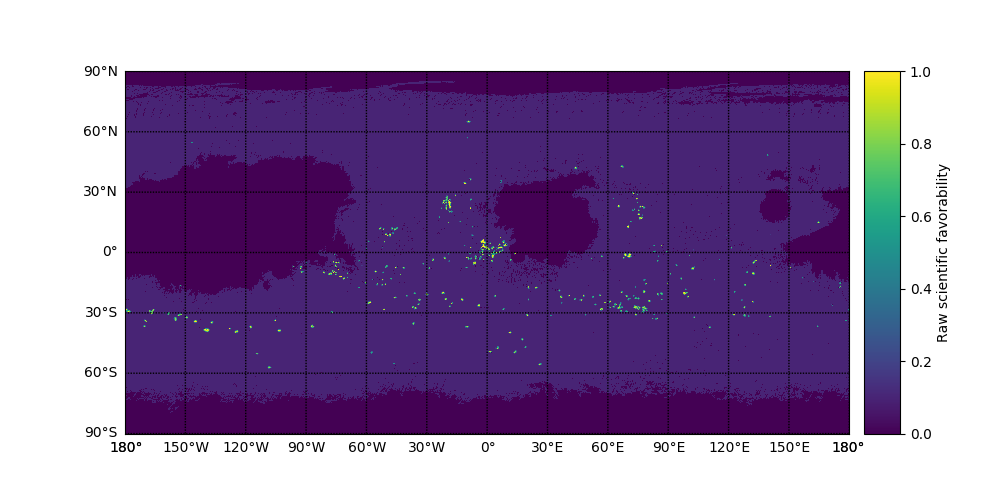

In [25]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection = 'cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, threshold_raw_scientific_favorability_array, 'Raw scientific favorability')
basemap1.drawmeridians(np.arange(0, 360, 30), labels = [False, False, False, True])
basemap1.drawparallels(np.arange(-90, 91, 30), labels = [True, False, False, False])
plt.show()

We export the map to a .tif file.

In [26]:
scenario_type_affix = '4_Scenarios_'

raster_raw_favorability = create_raster_from_array(threshold_raw_scientific_favorability_array,           
                                                   master_geotransform, 
                                                   master_projection,
                                                   file_type = 'GTiff',
                                                   file_path = base_folder + output_folder + 'Results_RawFavorability_Scientific_Threshold_' + scenario_type_affix + str(maximum_driving_time) + speed_affix + '.tif')
print_raster_info(raster_raw_favorability)
raster_raw_favorability = None

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


We import the raw landing favorability and combine it with the raw scientific favorability to get a raw selection favorability. This raw selection favorability takes into account the engineering constraints for landing, the presence of higher-resolution data, and the presence of high-priority scientific targets.

We want the areas favorable for landing and with scientific targets to stand out. But we also want the areas favorable for landing but without scientific targets to remain present with a low favorability. Hence the use of a gamma operator with a low gamma.

In [27]:
raster_raw_landing_favorability = open_raster(base_folder + output_folder + 'Results_RawFavorability_Landing.tif')
print_raster_info(raster_raw_landing_favorability)
raster_raw_landing_favorability_array = get_raster_array(raster_raw_landing_favorability)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [28]:
threshold_raw_selection_favorability_array = gamma_operation(0.35, raster_raw_landing_favorability_array,
                                                             threshold_raw_scientific_favorability_array)

<IPython.core.display.Javascript object>


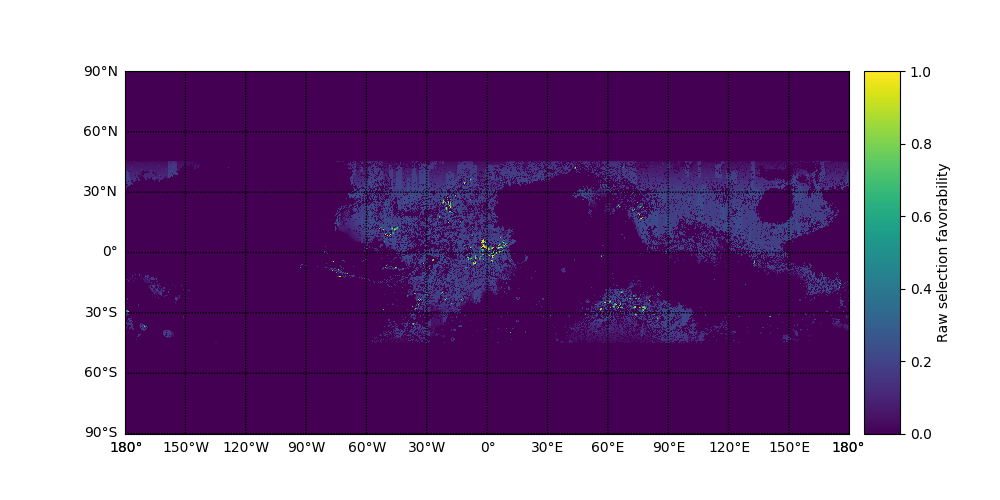

In [29]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection = 'cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, threshold_raw_selection_favorability_array, 'Raw selection favorability')
basemap1.drawmeridians(np.arange(0, 360, 30), labels = [False, False, False, True])
basemap1.drawparallels(np.arange(-90, 91, 30), labels = [True, False, False, False])
plt.show()

We export the map to a .tif file.

In [30]:
scenario_type_affix = '4_Scenarios_'

raw_raster_favorability = create_raster_from_array(threshold_raw_selection_favorability_array,           
                                                   master_geotransform, 
                                                   master_projection,
                                                   file_type = 'GTiff',
                                                   file_path = base_folder + output_folder + 'Results_RawFavorability_Selection_Threshold_' + scenario_type_affix + str(maximum_driving_time) + speed_affix + '.tif')
print_raster_info(raw_raster_favorability)
raw_raster_favorability = None

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


## Compute the best traverse paths

Now the idea is to perform a more thorough analysis than with the threshold targets. We use each threshold target as initial targets of possible rover's traverse paths, and see if it is possible to find paths visiting all the high-priority groups within the maximum driving time. Then, each path starting from a given target is ranked following:  
* If each target group from each priority level appears in the path.  
* The number of groups at each priority level.  
* The path’s sinuosity.  
* The remaining time after reaching all the high-priority groups.  
* The number of high-resolution data available along the path.
Only the highest-ranked path is kept for further computation.

&#9888; Computing the traverse path requires several hours.

In [31]:
from sklearn.externals.joblib import Parallel, delayed

def compute_traverse_paths_for_multiprocessing(threshold_targets):

    traverse_paths = defaultdict(list)
    
    for target in threshold_targets:

        initial_path = [((target, target_type), 0.) for target_type in target_types_at_cells[target]]
        open_paths = deque([initial_path])
        final_paths = [[] for scenario in scenarios_priorities]

        while open_paths:

            current_path = open_paths.pop()
            last_cell = current_path[-1][0][0]
            neighborhood = neighborhoods.get(last_cell)

            was_neighbor_added = False
            if neighborhood is not None:
                for neighbor in neighborhood:
                    if check_path_validity(current_path,
                                           neighbor,
                                           maximum_driving_time) == True:
                        new_path = list(current_path)
                        for target_type in target_types_at_cells[neighbor[0]]:
                            new_path.append(((neighbor[0], target_type),
                                              current_path[-1][1] + neighbor[1]))
                        open_paths.append(new_path)
                        was_neighbor_added = True
            if was_neighbor_added == False:
                scenarios_visited_groups_per_priorities, scenarios_path_duration = are_all_high_priority_in_path(current_path,
                                                                                                                 scenarios_groups_per_priority,
                                                                                                                 scenarios_target_priorities,
                                                                                                                 scenarios_target_groups)

                path_ranks = compute_path_rank(current_path,
                                               scenarios_visited_groups_per_priorities,
                                               scenarios_path_duration,
                                               maximum_driving_time,
                                               scenarios_target_priorities,
                                               scenarios_target_groups,
                                               scenarios_priorities,
                                               scenarios_groups_per_priority,
                                               high_resolution_arrays,
                                               rad_longitude_array,
                                               rad_latitude_array,
                                               mars_radius,
                                               group_weights,
                                               number_weight,
                                               data_weight,
                                               sinuosity_weight,
                                               duration_weight)

                for scenario, rank in enumerate(path_ranks):
                    if rank is not None:
                        final_paths[scenario].append((rank, scenarios_path_duration[scenario], current_path))
                    
        for scenario, paths in enumerate(final_paths):
            if paths:
                sorted_paths = sorted(paths)
                traverse_paths[tuple(sorted_paths[-1][2])].append((sorted_paths[-1][0],
                                                                   sorted_paths[-1][1],
                                                                   scenario))
                        
    return traverse_paths

In [32]:
global_threshold_targets = set()
for threshold_targets in scenarios_threshold_targets:
    global_threshold_targets.update(threshold_targets)
global_threshold_targets = list(global_threshold_targets)

In [33]:
print(len(global_threshold_targets))

7931


In [34]:
len(neighborhoods)

746051

Each component of the rank is weighted, here to emphasize on keeping paths which visit more target groups, especially the groups with the highest priority.

In [35]:
number_of_chunks = 8

group_weights = [range(len(priority), 0, -1) for priority in scenarios_groups_per_priority]
number_weight = 1
data_weight = 0.5
sinuosity_weight = 0.5
duration_weight = 0.5

rad_longitude_array = longitude_array*np.pi/180.
rad_latitude_array = latitude_array*np.pi/180.

In [36]:
%%time

chunk_size = math.ceil(len(global_threshold_targets)/number_of_chunks)
chunks = [global_threshold_targets[i:i + chunk_size] for i in range(0, len(global_threshold_targets), chunk_size)]

result_paths = Parallel(n_jobs = number_of_chunks)(delayed(compute_traverse_paths_for_multiprocessing)(chunk) for chunk in chunks)
traverse_paths = dict()
for paths in result_paths:
    traverse_paths.update(paths)

CPU times: user 1.65 s, sys: 1.32 s, total: 2.97 s
Wall time: 4.9 s


In [37]:
len(traverse_paths)

4507

In [38]:
scenarios_traverse_paths = [dict() for scenario in scenarios_priorities]

for path in traverse_paths:
    for scenario in traverse_paths[path]:
        scenario_path = []
        for target in path:
            if scenarios_target_priorities[scenario[2]][target[0][1]] is not None:
                scenario_target = ((target[0][0],
                                    scenarios_target_priorities[scenario[2]][target[0][1]],
                                    scenarios_target_groups[scenario[2]][target[0][1]],
                                    target_names[target[0][1]]),
                                   target[1])
                scenario_path.append(scenario_target)
        scenarios_traverse_paths[scenario[2]][tuple(scenario_path)] = (scenario[0], scenario[1])

We can look at the number of traverse paths for each scenarios.

In [39]:
for scenario_traverse_paths in scenarios_traverse_paths:
    print(len(scenario_traverse_paths))

2151
1404
358
1058


We can also look at how many paths would be available if we could not drive more than 9 sols (what Curiosity did during its prime mission).

In [40]:
for scenario_traverse_paths in scenarios_traverse_paths:
    length = 0
    for path in scenario_traverse_paths:
        if scenario_traverse_paths[path][1] <= 9:
            length += 1
    print(length)

129
108
39
64


We save the paths.

In [41]:
for traverse_paths, affix in zip(scenarios_traverse_paths, scenarios_exploration_affix):
    save_paths_to_csv_file(base_folder + output_folder + 'Results_List_Paths_' + affix + '.csv', traverse_paths)

In [42]:
neighborhoods = None
threshold_targets = None
global_threshold_targets = None

For each scenario, we apply the fast marching method from the initial targets of the traverse paths and we fuzzify the resulting travel time maps using the remaining time after removing the traverse time to visit all the high-priority groups within the path to the maximum driving time for the mission.

&#9888; The computation requires the computation of a partial travel time map for each path, and takes several hours.

In [43]:
def run_combined_fast_marching(paths):
    combined_traverse_array = np.full((master_height, master_width), 0.)

    for path in paths:
        remaining_time = maximum_driving_time - scenario_traverse_paths[path][1]

        initial_array = np.ones((master_height, master_width), dtype = np.int)
        initial_array[path[0][0][0]] = 0

        traverse_array = run_fast_marching(initial_array,
                                           raster_rover_speed_array,
                                           longitude_array,
                                           latitude_array,
                                           mars_radius,
                                           stopping_time = remaining_time + 5)

        fuzzified_traverse_array = trapezoidal_function(traverse_array[0,:,:],
                                                        0, 0, 0, remaining_time,
                                                        bottom_value = 0.1, plateau_value = 1, nan_value = 0)

        combined_traverse_array = union(combined_traverse_array, fuzzified_traverse_array)
        
    return combined_traverse_array

In [44]:
number_of_chunks = 20

In [45]:
%%time

path_combined_traverse_arrays = []

for scenario_traverse_paths in scenarios_traverse_paths:
    path_initial_targets_array = np.ones((master_height, master_width), dtype = np.int)
    for path in scenario_traverse_paths:
        path_initial_targets_array[path[0][0][0]] = 0

    background_array = run_fast_marching(path_initial_targets_array,
                                         raster_rover_speed_array,
                                         longitude_array,
                                         latitude_array,
                                         mars_radius)
    fuzzified_background_array = trapezoidal_function(background_array[0,:,:],
                                                      0, 0, 0, 0,
                                                      bottom_value = 0.1, plateau_value = 1, nan_value = 0)

    paths = list(scenario_traverse_paths.keys())
    chunk_size = math.ceil(len(paths)/number_of_chunks)
    chunks = [paths[i:i + chunk_size] for i in range(0, len(paths), chunk_size)]

    result_arrays = Parallel(n_jobs = number_of_chunks)(delayed(run_combined_fast_marching)(chunk) for chunk in chunks)
    path_combined_traverse_array = np.full((master_height, master_width), 0.)
    for result_array in result_arrays:
        path_combined_traverse_array = union(path_combined_traverse_array, result_array)
    path_combined_traverse_array[path_combined_traverse_array == 0.] = fuzzified_background_array[path_combined_traverse_array == 0.]

    path_combined_traverse_arrays.append(path_combined_traverse_array)

/home/grongier/Mars_Exploration/fuzzy_logic.py:67: RuntimeWarning: invalid value encountered in greater_equal
  indices = np.where(np.logical_and(x_start_plateau <= raster_array,
/home/grongier/Mars_Exploration/fuzzy_logic.py:68: RuntimeWarning: invalid value encountered in less_equal
  raster_array <= x_end_plateau))
/home/grongier/Mars_Exploration/fuzzy_logic.py:60: RuntimeWarning: invalid value encountered in greater
  indices = np.where(np.logical_and(x_end_plateau < raster_array,
/home/grongier/Mars_Exploration/fuzzy_logic.py:61: RuntimeWarning: invalid value encountered in less
  raster_array < x_end_slope))
/home/grongier/Mars_Exploration/fuzzy_logic.py:60: RuntimeWarning: invalid value encountered in greater
  indices = np.where(np.logical_and(x_end_plateau < raster_array,
/home/grongier/Mars_Exploration/fuzzy_logic.py:61: RuntimeWarning: invalid value encountered in less
  raster_array < x_end_slope))
/home/grongier/Mars_Exploration/fuzzy_logic.py:60: RuntimeWarning: invalid v

CPU times: user 37min 44s, sys: 7min 7s, total: 44min 52s
Wall time: 2h 55min


We export the maps to .tif files.

In [46]:
for path_combined_traverse_array, affix in zip(path_combined_traverse_arrays, scenarios_exploration_affix):
    raster_initial_scientific_targets = create_raster_from_array(path_combined_traverse_array,           
                                                                 master_geotransform, 
                                                                 master_projection,
                                                                 file_type = 'GTiff',
                                                                 file_path = base_folder + output_folder + 'Results_RawFavorability_Scientific_Paths_' + affix + '.tif')
    raster_initial_scientific_targets = None

Each scenario produces a raw scientific favorability map. Then, we can use each scenario individually to obtain four raw selection favorability maps. But we also can combine the scenarios alltogether into a single favorability map. We consider all the scenario to be equivalent, so we use an union.

Areas of high favorability mark a site with a traverse path for the rover nearby.

In [47]:
paths_raw_scientific_favorability_array = np.empty((master_height, master_width))

for path_combined_traverse_array in path_combined_traverse_arrays:
    paths_raw_scientific_favorability_array = union(paths_raw_scientific_favorability_array,
                                                    path_combined_traverse_array)

<IPython.core.display.Javascript object>


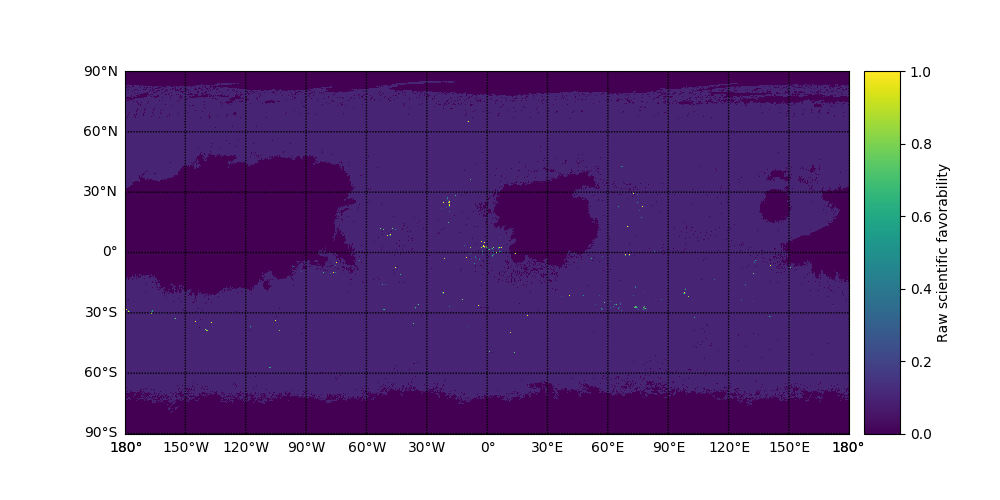

In [48]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection = 'cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, paths_raw_scientific_favorability_array, 'Raw scientific favorability')
basemap1.drawmeridians(np.arange(0, 360, 30), labels = [False, False, False, True])
basemap1.drawparallels(np.arange(-90, 91, 30), labels = [True, False, False, False])
plt.show()

We export the map to a .tif file.

In [49]:
scenario_type_affix = '4_Scenarios_'

raster_raw_favorability = create_raster_from_array(paths_raw_scientific_favorability_array,           
                                                   master_geotransform, 
                                                   master_projection,
                                                   file_type = 'GTiff',
                                                   file_path = base_folder + output_folder + 'Results_RawFavorability_Scientific_Paths_' + scenario_type_affix + str(maximum_driving_time) + speed_affix + '.tif')
print_raster_info(raster_raw_favorability)
raster_raw_favorability = None

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


We combine the raw landing favorability with the raw scientific favorability to get a raw selection favorability. This raw selection favorability takes into account the engineering constraints for landing, the presence of higher-resolution data, and the presence of traverse paths.

We want the areas favorable for landing and with scientific targets to stand out. But we also want the areas favorable for landing but without scientific targets to remain present with a low favorability. Hence the use of a gamma operator with a low gamma.

In [50]:
path_raw_selection_favorability_array = gamma_operation(0.35, raster_raw_landing_favorability_array,
                                                        paths_raw_scientific_favorability_array)

<IPython.core.display.Javascript object>


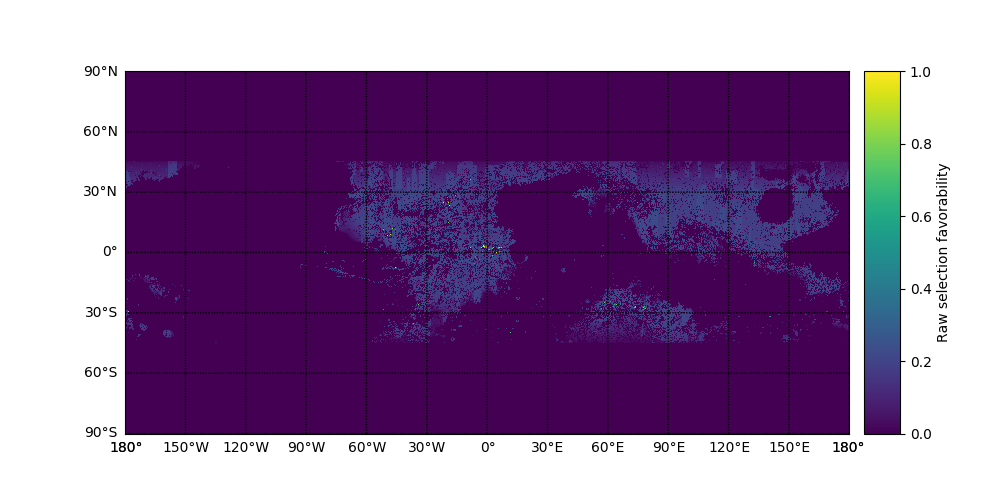

In [51]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection = 'cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, path_raw_selection_favorability_array, 'Raw selection favorability')
basemap1.drawmeridians(np.arange(0, 360, 30), labels = [False, False, False, True])
basemap1.drawparallels(np.arange(-90, 91, 30), labels = [True, False, False, False])
plt.show()

We export the map to a .tif file.

In [52]:
scenario_type_affix = '4_Scenarios_'

raw_raster_favorability = create_raster_from_array(path_raw_selection_favorability_array,           
                                                   master_geotransform, 
                                                   master_projection,
                                                   file_type = 'GTiff',
                                                   file_path = base_folder + output_folder + 'Results_RawFavorability_Selection_Paths_' + scenario_type_affix + str(maximum_driving_time) + speed_affix + '.tif')
print_raster_info(raw_raster_favorability)
raw_raster_favorability = None

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )
